In [66]:
import os
import cv2
import glob
import math
import random
import pathlib
import numpy as np
import tensorflow as tf
from keras import layers
from os.path import join
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib import gridspec
from scipy import signal
from scipy.fft import fftshift
import numpy as np
import pandas as pd
import os
from matplotlib import gridspec
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization

from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape, BatchNormalization, Activation
from tensorflow.keras.models import Model
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [67]:
base_dir = os.getcwd()
print(f'current directory: {base_dir}')

dataset_dir = os.path.join(base_dir, 'data')
print(f'datasets directory: {dataset_dir}')

current directory: /Users/mahdiehmoghiseh/Desktop/sbu/project-s
datasets directory: /Users/mahdiehmoghiseh/Desktop/sbu/project-s/data


In [68]:
import os
import numpy as np

norm_dir = './data/norm'
sch_dir = './data/sch'

n_channels = 16
n_times = 7680

def load_eeg_data(directory, label):
    eeg_data = []
    labels = []
    filenames = sorted([f for f in os.listdir(directory) if f.endswith('.eea')])

    for filename in filenames:
        file_path = os.path.join(directory, filename)

        data = np.loadtxt(file_path)

        data = data.reshape(n_times, n_channels).T

        eeg_data.append(data)
        labels.append(label)

    return np.array(eeg_data), np.array(labels)

norm_data, norm_labels = load_eeg_data(norm_dir, 0)
sch_data, sch_labels = load_eeg_data(sch_dir, 1)

X = np.concatenate((norm_data, sch_data), axis=0)
y = np.concatenate((norm_labels, sch_labels), axis=0)

X = X / np.max(X)

# Shuffle the dataset
shuffle_indices = np.random.permutation(X.shape[0])
X = X[shuffle_indices]
y = y[shuffle_indices]

print('Data shape:', X.shape)
print('Labels shape:', y.shape)

n_samples = X.shape[0]
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

def chunk_data(X, y, chunk_size):
    X_chunks = []
    y_chunks = []

    # for i in range(X.shape[0]):
    #     # Each signal is chunked into non-overlapping segments of size chunk_size
    #     for start in range(0, X.shape[2], chunk_size):
    #         end = start + chunk_size
    #         if end <= X.shape[2]:
    #             X_chunks.append(X[i, :, start:end])
    #             y_chunks.append(y[i])
    X_chunks = X
    y_chunks = y

    return np.array(X_chunks), np.array(y_chunks)

chunk_size = 640

# Chunk the data after the split into train, validation, and test sets
X_train_chunked, y_train_chunked = chunk_data(X_train, y_train, chunk_size)
X_val_chunked, y_val_chunked = chunk_data(X_val, y_val, chunk_size)
X_test_chunked, y_test_chunked = chunk_data(X_test, y_test, chunk_size)

print('Chunked train set shape:', X_train_chunked.shape, 'Chunked train labels shape:', y_train_chunked.shape)
print('Chunked validation set shape:', X_val_chunked.shape, 'Chunked validation labels shape:', y_val_chunked.shape)
print('Chunked test set shape:', X_test_chunked.shape, 'Chunked test labels shape:', y_test_chunked.shape)

Data shape: (84, 16, 7680)
Labels shape: (84,)
Chunked train set shape: (67, 16, 7680) Chunked train labels shape: (67,)
Chunked validation set shape: (8, 16, 7680) Chunked validation labels shape: (8,)
Chunked test set shape: (9, 16, 7680) Chunked test labels shape: (9,)


In [69]:
from tensorflow.keras.regularizers import l2


n_samples, n_channels, n_times = X_train_chunked.shape

# Encoder
input_layer = Input(shape=(n_channels, n_times))  # (65, 1024)
x = Conv1D(filters=64, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(0.01))(input_layer)  # (65, 512)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters=256, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(0.001))(x)  # (65, 256)
x = BatchNormalization()(x)
x = Activation('relu')(x)

shape_before_flattening = x.shape[1:]  # (timesteps, 32)
x = Flatten()(x)
encoded = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)  # Latent space with L2 regularization

# Decoder
x = Dense(np.prod(shape_before_flattening), kernel_regularizer=l2(0.001))(encoded)
x = Reshape(shape_before_flattening)(x)  # Reshape to (timesteps, 32)

x = Conv1DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(0.001))(x)  # (65, 512)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1DTranspose(filters=n_times, kernel_size=3, strides=2, padding='same', kernel_regularizer=l2(0.001))(x)  # (65, 1024)
x = BatchNormalization()(x)

# Cropping if necessary
if x.shape[1] > n_channels:
    x = Cropping1D(cropping=(0, x.shape[1] - n_channels))(x)

decoded = Activation('sigmoid')(x)

decoded = Reshape((n_channels, n_times))(decoded)  # (65, 1024)

# Autoencoder Model
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
autoencoder.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 16, 7680)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_8 (Conv1D)               │ (None, 8, 64)          │     1,474,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_16 (Activation)      │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 4, 256)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_17 (Activation)      │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       132,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 4, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_8              │ (None, 8, 64)          │        49,216 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 8, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_18 (Activation)      │ (None, 8, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_9              │ (None, 16, 7680)       │     1,482,240 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 7680)       │        30,720 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_19 (Activation)      │ (None, 16, 7680)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_9 (Reshape)             │ (None, 16, 7680)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,351,040 (12.78 MB)

 Trainable params: 3,334,912 (12.72 MB)

 Non-trainable params: 16,128 (63.00 KB)

In [70]:
from keras.callbacks import EarlyStopping
history = autoencoder.fit(
    X_train_chunked, X_train_chunked,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_chunked, X_val_chunked),
    # validation_split=0.2,
    callbacks=[ModelCheckpoint("autoencoder.keras", save_best_only=True), EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 2.3353 - val_loss: 2.2358
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 2.2525 - val_loss: 2.1601
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.1741 - val_loss: 2.0877
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 2.0978 - val_loss: 2.0191
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 2.0288 - val_loss: 1.9535
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1.9568 - val_loss: 1.8901
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.8949 - val_loss: 1.8296
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.8273 - val_loss: 1.7717
Epoch 9/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.7729 - val_loss: 1.7166
Epoch 10/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.7105 - val_loss: 1.6644
Epoch 11/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 1.6579 - val_loss: 1.6145
Epoch 12/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.6056 - val_l

In [71]:
conv1_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv1d_8').output)
conv2_layer_model = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('conv1d_9').output)

conv1_outputs = conv1_layer_model.predict(X_train_chunked)
conv2_outputs = conv2_layer_model.predict(X_train_chunked)

def calculate_energy(conv_outputs):
    return np.sum(np.square(conv_outputs), axis=(1, 2))

healthy_indices = np.where(y_train == 0)[0]
diseased_indices = np.where(y_train == 1)[0]

energy_conv1_healthy = calculate_energy(conv1_outputs[healthy_indices])
energy_conv1_diseased = calculate_energy(conv1_outputs[diseased_indices])

energy_conv2_healthy = calculate_energy(conv2_outputs[healthy_indices])
energy_conv2_diseased = calculate_energy(conv2_outputs[diseased_indices])

print("Conv1 Energy Range for Healthy Samples:", np.max(energy_conv1_healthy) - np.min(energy_conv1_healthy))
print("Conv1 Energy Range for Diseased Samples:", np.max(energy_conv1_diseased) - np.min(energy_conv1_diseased))
print("Conv2 Energy Range for Healthy Samples:", np.max(energy_conv2_healthy) - np.min(energy_conv2_healthy))
print("Conv2 Energy Range for Diseased Samples:", np.max(energy_conv2_diseased) - np.min(energy_conv2_diseased))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Conv1 Energy Range for Healthy Samples: 14.985101
Conv1 Energy Range for Diseased Samples: 121.08273
Conv2 Energy Range for Healthy Samples: 67.85033
Conv2 Energy Range for Diseased Samples: 379.33316


In [72]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_8').output)
encoded_features = encoder.predict(X_train_chunked)
encoded_features_test = encoder.predict(X_test_chunked)
# Fit and transform the encoded features
from sklearn.preprocessing import StandardScaler
# Initialize StandardScaler
scaler = StandardScaler()
encoded_features_scaled = scaler.fit_transform(encoded_features)
encoded_features_test_scaled = scaler.transform(encoded_features_test)

# Convert back to torch tensors
encoded_features = torch.tensor(encoded_features_scaled).float()
encoded_features_test = torch.tensor(encoded_features_test_scaled).float()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [73]:
# Correctly create tensors from existing tensors
encoded_features = encoded_features.clone().detach().float()
labels = torch.tensor(y_train_chunked).long()  # Assuming y_train_chunked is a list or NumPy array
encoded_features_test = encoded_features_test.clone().detach().float()
labels_test = torch.tensor(y_test_chunked).long()  # Assuming y_test_chunked is a list or NumPy array

In [74]:
import torch.nn as nn

class SincConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SincConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)

    def forward(self, x):
        x = self.conv(x)
        return x

class SincNet(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout_p=0.6):
        super(SincNet, self).__init__()
        self.sinc_conv = SincConv(in_channels=1, out_channels=64, kernel_size=3)  # Increased number of channels

        self.fc1 = nn.Linear(input_dim * 64, 64)  # Increased dimensions
        self.fc2 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(dropout_p)
        self.relu = nn.ReLU()
        self.batch_norm = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.sinc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [75]:
import torch.optim as optim
input_dim = encoded_features.shape[1]
model = SincNet(input_dim=input_dim)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.0001)  # Reduce LR by 0.1 every 10 epochs

In [76]:
dataset = TensorDataset(encoded_features, labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

num_epochs = 200
losses = []
accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, targets in dataloader:
        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs, 1)
        total_preds += targets.size(0)
        correct_preds += (predicted == targets).sum().item()

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_preds / total_preds
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


model_path = 'eeg_model.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': num_epochs,
    'losses': losses,
    'accuracies': accuracies
}, model_path)

print("Model saved successfully.")

Epoch [1/200], Loss: 0.7335, Accuracy: 0.4328
Epoch [2/200], Loss: 0.7406, Accuracy: 0.5970
Epoch [3/200], Loss: 0.6940, Accuracy: 0.6866
Epoch [4/200], Loss: 0.8000, Accuracy: 0.6716
Epoch [5/200], Loss: 0.6124, Accuracy: 0.5821
Epoch [6/200], Loss: 0.5517, Accuracy: 0.7612
Epoch [7/200], Loss: 0.4342, Accuracy: 0.7313
Epoch [8/200], Loss: 0.4982, Accuracy: 0.8358
Epoch [9/200], Loss: 0.4197, Accuracy: 0.7015
Epoch [10/200], Loss: 0.5727, Accuracy: 0.7463
Epoch [11/200], Loss: 0.6069, Accuracy: 0.7164
Epoch [12/200], Loss: 0.6619, Accuracy: 0.7761
Epoch [13/200], Loss: 0.3969, Accuracy: 0.7015
Epoch [14/200], Loss: 0.3339, Accuracy: 0.7612
Epoch [15/200], Loss: 0.5611, Accuracy: 0.7313
Epoch [16/200], Loss: 0.2743, Accuracy: 0.8358
Epoch [17/200], Loss: 0.6061, Accuracy: 0.7164
Epoch [18/200], Loss: 0.5452, Accuracy: 0.7612
Epoch [19/200], Loss: 0.4840, Accuracy: 0.7612
Epoch [20/200], Loss: 0.3206, Accuracy: 0.7164
Epoch [21/200], Loss: 0.6437, Accuracy: 0.7761
Epoch [22/200], Loss: 

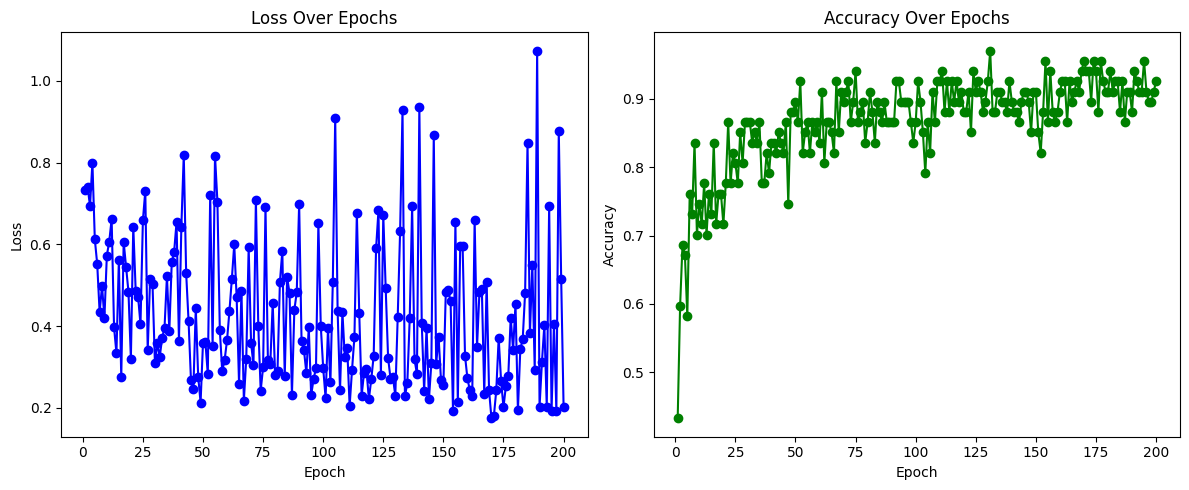

In [77]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, marker='o', color='b')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, marker='o', color='g')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [78]:
from sklearn.metrics import accuracy_score

# Load the checkpoint safely with weights_only=True
checkpoint = torch.load(model_path, weights_only=True)
print(checkpoint.keys())  # Confirm available keys in the checkpoint

# Load model state dict (with strict=False if needed)
model.load_state_dict(checkpoint['model_state_dict'], strict=False)

# Load optimizer state dict
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# Use finetune_epochs instead of epoch
finetune_epochs = checkpoint.get('finetune_epochs', None)  # Get finetune_epochs key
losses = checkpoint.get('losses', [])   # Use an empty list if not present
accuracies = checkpoint.get('accuracies', [])  # Use an empty list if not present

# Set model to evaluation mode
model.eval()
print(f"Model loaded successfully, resuming from fine-tuning epochs: {finetune_epochs}.")
with torch.no_grad():
    outputs_test = model(encoded_features_test)
    _, predicted_test = torch.max(outputs_test, 1)
    accuracy_test = accuracy_score(labels_test.numpy(), predicted_test.numpy())
    print(f'Final Model Accuracy: {accuracy_test:.4f}')

dict_keys(['model_state_dict', 'optimizer_state_dict', 'epoch', 'losses', 'accuracies'])
Model loaded successfully, resuming from fine-tuning epochs: None.
Final Model Accuracy: 0.6667


In [79]:
# pretrain
pretrain_size = int(0.2 * X_train.shape[0])  # 10% of the training data

X_train_pretrain = X_train_chunked[:pretrain_size]
y_train_pretrain = y_train_chunked[:pretrain_size]

# fine-tuning
X_train = X_train_chunked[pretrain_size:]
y_train = y_train_chunked[pretrain_size:]

In [80]:
encoder = Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('dense_8').output)

encoded_features_pretrain = encoder.predict(X_train_pretrain)
encoded_features = encoder.predict(X_train_chunked)
encoded_features_test = encoder.predict(X_test_chunked)

encoded_features_pretrain = torch.tensor(encoded_features_pretrain).float()
encoded_features = torch.tensor(encoded_features).float()
encoded_features_test = torch.tensor(encoded_features_test).float()

labels_pretrain = torch.tensor(y_train_pretrain).long()
labels = torch.tensor(y_train_chunked).long()
labels_test = torch.tensor(y_test_chunked).long()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [81]:
class SincConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(SincConv, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=kernel_size // 2)
        self.batch_norm = nn.BatchNorm1d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        return x

class SincNet(nn.Module):
    def __init__(self, input_dim, num_classes=2, dropout_p=0.6):
        super(SincNet, self).__init__()
        self.sinc_conv = SincConv(in_channels=1, out_channels=64, kernel_size=3)  # SincConv layer

        self.fc1 = nn.Linear(input_dim * 64, 64)
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_p)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.sinc_conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.batch_norm1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [82]:
input_dim = encoded_features.shape[1]
sincnet = SincNet(input_dim=input_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(sincnet.parameters(), lr=0.00001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

pretrain_dataset = TensorDataset(encoded_features_pretrain, labels_pretrain)
pretrain_dataloader = DataLoader(pretrain_dataset, batch_size=64, shuffle=True)

train_dataset = TensorDataset(encoded_features, labels)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

num_pretrain_epochs = 100  # Number of pretraining epochs
num_finetune_epochs = 200  # Number of fine-tuning epochs

In [83]:
model_path = 'sincnet_model.pth'

print("Pretraining SincNet...")
for epoch in range(num_pretrain_epochs):
    sincnet.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, targets in pretrain_dataloader:
        optimizer.zero_grad()

        outputs = sincnet(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_preds += targets.size(0)
        correct_preds += (predicted == targets).sum().item()

    avg_loss = running_loss / len(pretrain_dataloader)
    accuracy = correct_preds / total_preds
    print(f"Pretrain Epoch [{epoch+1}/{num_pretrain_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Save the model after pretraining
torch.save({
    'model_state_dict': sincnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'pretrain_epochs': num_pretrain_epochs
}, model_path)

print("Model saved successfully after pretraining.")

Pretraining SincNet...
Pretrain Epoch [1/100], Loss: 0.7926, Accuracy: 0.5385
Pretrain Epoch [2/100], Loss: 0.7156, Accuracy: 0.5385
Pretrain Epoch [3/100], Loss: 0.5828, Accuracy: 0.6154
Pretrain Epoch [4/100], Loss: 0.7048, Accuracy: 0.4615
Pretrain Epoch [5/100], Loss: 0.7136, Accuracy: 0.4615
Pretrain Epoch [6/100], Loss: 0.6000, Accuracy: 0.5385
Pretrain Epoch [7/100], Loss: 0.6327, Accuracy: 0.6154
Pretrain Epoch [8/100], Loss: 0.5648, Accuracy: 0.6923
Pretrain Epoch [9/100], Loss: 0.6134, Accuracy: 0.6923
Pretrain Epoch [10/100], Loss: 0.5899, Accuracy: 0.6923
Pretrain Epoch [11/100], Loss: 0.5768, Accuracy: 0.8462
Pretrain Epoch [12/100], Loss: 0.5210, Accuracy: 0.7692
Pretrain Epoch [13/100], Loss: 0.4411, Accuracy: 0.8462
Pretrain Epoch [14/100], Loss: 0.5578, Accuracy: 0.6923
Pretrain Epoch [15/100], Loss: 0.3959, Accuracy: 1.0000
Pretrain Epoch [16/100], Loss: 0.6026, Accuracy: 0.7692
Pretrain Epoch [17/100], Loss: 0.5128, Accuracy: 0.7692
Pretrain Epoch [18/100], Loss: 0.4

In [84]:
print("Fine-tuning SincNet...")
losses = []
accuracies = []
for epoch in range(num_finetune_epochs):
    sincnet.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, targets in train_dataloader:
        optimizer.zero_grad()

        outputs = sincnet(inputs)

        loss = criterion(outputs, targets)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_preds += targets.size(0)
        correct_preds += (predicted == targets).sum().item()

    avg_loss = running_loss / len(train_dataloader)
    accuracy = correct_preds / total_preds
    losses.append(avg_loss)
    accuracies.append(accuracy)

    print(f"Fine-tune Epoch [{epoch+1}/{num_finetune_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")


torch.save({
    'model_state_dict': sincnet.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'finetune_epochs': num_finetune_epochs,
    'losses': losses,
    'accuracies': accuracies
}, model_path)

print("Model saved successfully after fine-tuning.")

Fine-tuning SincNet...
Fine-tune Epoch [1/200], Loss: 0.8840, Accuracy: 0.5373
Fine-tune Epoch [2/200], Loss: 0.8711, Accuracy: 0.5373
Fine-tune Epoch [3/200], Loss: 0.6520, Accuracy: 0.5522
Fine-tune Epoch [4/200], Loss: 0.7530, Accuracy: 0.5970
Fine-tune Epoch [5/200], Loss: 0.7266, Accuracy: 0.5821
Fine-tune Epoch [6/200], Loss: 0.5128, Accuracy: 0.5672
Fine-tune Epoch [7/200], Loss: 0.7354, Accuracy: 0.5522
Fine-tune Epoch [8/200], Loss: 0.7467, Accuracy: 0.5075
Fine-tune Epoch [9/200], Loss: 0.7871, Accuracy: 0.5672
Fine-tune Epoch [10/200], Loss: 0.6082, Accuracy: 0.5672
Fine-tune Epoch [11/200], Loss: 0.5991, Accuracy: 0.5821
Fine-tune Epoch [12/200], Loss: 0.7836, Accuracy: 0.5522
Fine-tune Epoch [13/200], Loss: 0.6354, Accuracy: 0.5821
Fine-tune Epoch [14/200], Loss: 0.6911, Accuracy: 0.5821
Fine-tune Epoch [15/200], Loss: 0.8538, Accuracy: 0.6119
Fine-tune Epoch [16/200], Loss: 0.6575, Accuracy: 0.5821
Fine-tune Epoch [17/200], Loss: 0.5325, Accuracy: 0.6866
Fine-tune Epoch [

In [85]:
checkpoint = torch.load('sincnet_model.pth')
sincnet.load_state_dict(checkpoint['model_state_dict'], strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

sincnet.eval()

with torch.no_grad():
    outputs_test = sincnet(encoded_features_test)
    _, predicted_test = torch.max(outputs_test, 1)
    test_accuracy = (predicted_test == labels_test).sum().item() / labels_test.size(0)
    print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.5556


/var/folders/5h/kd8ml0ts1y3_77tnnr4njbvw0000gn/T/ipykernel_94053/1103552355.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('sincnet_model.pth')


####